  $G_i + P \quad[k^{b_P}_i]<->[k^{u_P}_i] \quad  G_i:P \\
    G_i:P \quad  --> [k_i^{tx}] \quad  G_i + P + T_i \\
    T_i + R \quad  [k^{b_R}_i]<->[k^{u_R}_i]\quad   T_i:R \\
    T_i:R  \quad -->[k_i^{tl}]\quad T_i + R + X_i \\
    T_i + E \quad  [k^{b_E}_i]<->[k^{u_E}_i] \quad  T_i:E \\
    T_i:E \quad-->[\delta_i]\quad E \\
    X \quad-->[d]\quad $

In [1]:
%matplotlib inline
from auto_reduce import *
import numpy as np
from sympy import symbols

In [2]:
# Post conservation law and other approximations phenomenological model at the RNA level
n = 9 # Number of states : G, P, C1, T, R, C2, E, C3, X
nouts = 1 # Number of outputs, X_i

# Inputs by user 
x_init = np.zeros(n)
x_init[0] = 10
x_init[1] = 10000
x_init[4] = 10000
x_init[6] = 10000
C = np.zeros((nouts,n), dtype=int)
C[0][8] = 1

nstates_tol = 8
error_tol = 3000
# System dynamics symbolically

# k_bp, k_up, k_tx, k_br, k_ur, k_tl, k_be, k_ue, d_i, d = params, len(params) = 10

x0 = symbols('G')
x1 = symbols('P')
x2 = symbols('C1') # G:P
x3 = symbols('T')
x4 = symbols('R')
x5 = symbols('C2') # T:R
x6 = symbols('E')
x7 = symbols('C3') # T:E
x8 = symbols('X')

x = [x0, x1, x2, x3, x4, x5, x6, x7, x8]

k_bp = symbols('k_bp')
k_up = symbols('k_up')
k_tx = symbols('k_tx')
k_br = symbols('k_br')
k_ur = symbols('k_ur')
k_tl = symbols('k_tl')
k_be = symbols('k_be')
k_ue = symbols('k_ue')
d_i = symbols('d_i')
d = symbols('d')

E_tot = symbols('E_tot')
P_tot = symbols('P_tot')
R_tot = symbols('R_tot')
params = [k_bp, k_up, k_tx, k_br, k_ur, k_tl, k_be, k_ue, d_i, d, E_tot, P_tot, R_tot]
f0 = (k_bp + k_tx) * x2 - k_up * x0 * x1
f1 = (k_bp + k_tx) * x2 - k_up * x0 * x1
f2 = k_bp * x0 * x1 - (k_up + k_tx)*x2
f3 = k_tx * x2 + k_ur * x5 - k_br * x3 * x4
f4 = (k_ur + k_tl) * x5 - k_br * x3 * x4
f5 = k_br * x3 * x4 - (k_ur + k_tl) * x5
f6 = (k_ue + d_i) * x7 - k_be * x3 * x6
f7 = k_be * x3 * x6 - (k_ue + d_i) * x7
f8 = k_tl * x5 - d * x8
    
f = [f0,f1,f2,f3,f4,f5,f6,f7,f8]
# parameter values
params_values = [100, 10, 4, 10, 0.25, 2, 10, 0.5, 1, 1, 1000, 1000, 1000]
sys = System(x, f, params = params, params_values = params_values, C = C, x_init = x_init)

In [ ]:
from auto_reduce.utils import get_ODE
timepoints_ode = np.linspace(0, 20, 100)
sys_ode = get_ODE(sys, timepoints_ode)
sol = sys_ode.solve_system().T
import matplotlib.pyplot as plt
plt.plot(timepoints_ode, np.transpose(np.array(C)@sol))
plt.xlabel('Time')
plt.ylabel('[Outputs]')
plt.show()

In [ ]:
sol

In [ ]:
from auto_reduce.utils import get_SSM
timepoints_ssm = np.linspace(0,100,10)
sys_ssm = get_SSM(sys, timepoints_ssm)
# Ss = sys_ssm.compute_SSM() # len(timepoints) x len(params) x len(states)
# out_Ss = []
# for i in range(len(params)):
#     out_Ss.append((np.array(C)@(Ss[:,i,:].T)))
# out_Ss = np.reshape(np.array(out_Ss), (len(timepoints_ssm), len(params), nouts))

In [ ]:
J1 = sys_ssm.compute_J([10,10,1000,5,10000,100,10000,5,10])
import scipy
scipy.linalg.eigvals(J1)

In [ ]:
np.ones(9)

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
for j in range(nouts):
    sn.heatmap(out_Ss[:,:,j].T)
    plt.xlabel('Time')
    plt.ylabel('Parameters')
    plt.title('Sensitivity of output[{0}] with respect to all parameters'.format(j))
    plt.show()

In [3]:
from auto_reduce.utils import reduce
timepoints_ssm = np.linspace(0,2,10)
timepoints_ode = np.linspace(0,2,100)
sys_reduce = reduce(sys, timepoints_ode, timepoints_ssm)
sys_reduce.nstates_tol = 5

In [4]:
G, P, C1, T, R, C2, E, C3, X = sys.x
conserved_quantities = [P + C1 - P_tot, R + C2 - R_tot, E + C3 - E_tot]
states_to_eliminate = [1,4,6]
f_cons = sys_reduce.set_conservation_laws(conserved_quantities, states_to_eliminate)

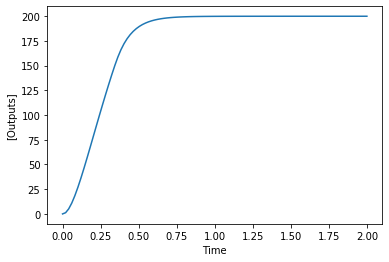

In [5]:
from auto_reduce.utils import get_ODE
timepoints_ode = np.linspace(0, 2, 100)
params_values = [100, 10, 4, 10, 0.25, 2, 10, 0.5, 1, 10, 1000, 1000, 1000]
sys_reduce.params_values = params_values
sys_ode = get_ODE(sys_reduce, timepoints_ode)
sol = sys_ode.solve_system().T
import matplotlib.pyplot as plt
plt.plot(timepoints_ode, np.transpose(np.array(sys_reduce.C)@sol))
plt.xlabel('Time')
plt.ylabel('[Outputs]')
plt.show()

In [6]:
results = sys_reduce.reduce_Cx()
# reduced_sys, fast_ss = sys_reduce.solve_timescale_separation([0,2,5])
# sys_reduce.get_robustness_metric(reduced_sys, fast_ss, [0,2,5])
# sys_reduce.get_error_metric(reduced_sys)

attempting : [5]
The time-scale separation that retains states [5] does not work
attempting : [0, 5]
The time-scale separation that retains states [0, 5] does not work
attempting : [1, 5]
The time-scale separation that retains states [1, 5] does not work
attempting : [2, 5]
The time-scale separation that retains states [2, 5] does not work
attempting : [3, 5]
The time-scale separation that retains states [3, 5] does not work
attempting : [4, 5]
The time-scale separation that retains states [4, 5] does not work
attempting : [0, 1, 5]
The time-scale separation that retains states [0, 1, 5] does not work
attempting : [0, 2, 5]


C:\Users\apand\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


attempting : [0, 3, 5]
attempting : [0, 4, 5]
The time-scale separation that retains states [0, 4, 5] does not work
attempting : [1, 2, 5]
attempting : [1, 3, 5]
attempting : [1, 4, 5]
The time-scale separation that retains states [1, 4, 5] does not work
attempting : [2, 3, 5]
The time-scale separation that retains states [2, 3, 5] does not work
attempting : [2, 4, 5]
The time-scale separation that retains states [2, 4, 5] does not work
attempting : [3, 4, 5]
The time-scale separation that retains states [3, 4, 5] does not work
attempting : [0, 1, 2, 5]
attempting : [0, 1, 3, 5]
attempting : [0, 1, 4, 5]
The time-scale separation that retains states [0, 1, 4, 5] does not work
attempting : [0, 2, 3, 5]
attempting : [0, 2, 4, 5]
attempting : [0, 3, 4, 5]
attempting : [1, 2, 3, 5]
attempting : [1, 2, 4, 5]
attempting : [1, 3, 4, 5]
attempting : [2, 3, 4, 5]
The time-scale separation that retains states [2, 3, 4, 5] does not work
attempting : [0, 1, 2, 3, 5]
attempting : [0, 1, 2, 4, 5]
at

In [ ]:
reduced_sys, fast_ss = sys_reduce.solve_timescale_separation([1,3,5])
reduced_sys.f[1]
# from auto_reduce.utils import get_ODE
x_sol_hat = get_ODE(sys_reduce.get_system(), timepoints_ode).solve_system()

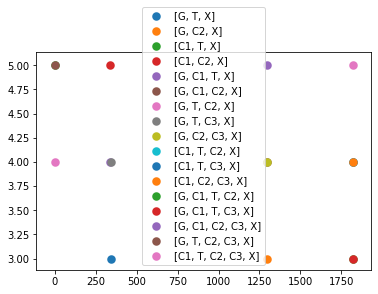

In [13]:
# results
import matplotlib.pyplot as plt
for key, value in results.items():
    plt.scatter(value[0], key.n,linewidths = 2.5, label = str(key.x))
plt.legend()
plt.savefig('enzymatic_rxn_e.svg')

In [ ]:
def get_gamma(system_obj, input, output):
    

In [ ]:
import matplotlib.pyplot as plt
y_hat = sys_reduce.C@x_sol_hat.T
plt.plot(timepoints_ode,y_hat.T)

In [ ]:
from auto_reduce.utils import reduce_utils
rx = reduce_utils(sys_reduce)
rx.write_results('gene_expression_results.txt')